In [74]:
# Import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")



In [48]:
df = pd.read_csv("../data/processed/graph_merge.csv")
print(f"Dataset loaded: {len(df):,} emails")
print(f"Columns: {df.columns.tolist()}")
print(df['label'].value_counts())
print(f"Spam rate: {df['label'].mean()*100:.1f}%")

Dataset loaded: 49,529 emails
Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
label
1    28126
0    21403
Name: count, dtype: int64
Spam rate: 56.8%


In [49]:
df = df.dropna(subset=['sender', 'receiver'])
df['sender'] = df['sender'].astype(str).str.strip().str.lower()
df['receiver'] = df['receiver'].astype(str).str.strip().str.lower()
df = df[(df['sender'] != 'nan') & (df['receiver'] != 'nan')]
print(f"After cleaning: {len(df):,} emails")
G = nx.DiGraph()

for idx, row in df.iterrows():
    sender = row['sender']
    receiver = row['receiver']
    is_spam = row['label']
    
    if G.has_edge(sender, receiver):
        G[sender][receiver]['weight'] += 1
        G[sender][receiver]['spam_count'] += is_spam
        G[sender][receiver]['ham_count'] += (1 - is_spam)
    else:
        G.add_edge(sender, receiver, 
                   weight=1, 
                   spam_count=is_spam,
                   ham_count=1-is_spam)

print(f"  Nodes (unique emails):     {G.number_of_nodes():,}")
print(f"  Edges (connections):       {G.number_of_edges():,}")
print(f"  Network density:           {nx.density(G):.6f}")
print(f"  Avg degree:                {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")

After cleaning: 49,529 emails
  Nodes (unique emails):     37,670
  Edges (connections):       37,171
  Network density:           0.000026
  Avg degree:                1.97


In [50]:
print("\n[1/4] Computing basic centrality measures...")
pagerank = nx.pagerank(G, max_iter=50)  # Keep for neighbor_pagerank calculation
clustering = nx.clustering(G.to_undirected())
out_degrees = dict(G.out_degree())
in_degrees = dict(G.in_degree())

print("[2/4] Computing closeness and eigenvector centrality...")
closeness = nx.closeness_centrality(G)
try:
    eigenvector = nx.eigenvector_centrality(G, max_iter=100)
except:
    print("   Warning: Eigenvector centrality failed, using zeros")
    eigenvector = {node: 0 for node in G.nodes()}

# HITS algorithm (Hub scores only, authority removed)
print("[3/4] Computing HITS (hub scores)...")
hits_h, hits_a = nx.hits(G, max_iter=100)

# Additional structural features
print("[4/4] Computing additional structural features...")
# Remove self loops immediately after building graph
G.remove_edges_from(nx.selfloop_edges(G))
core_number = nx.core_number(G)  # k-core decomposition
triangles = nx.triangles(G.to_undirected())  # number of triangles

# Average neighbor degree
avg_neighbor_deg = nx.average_neighbor_degree(G)

# Harmonic centrality (works better for disconnected graphs)
print("   Computing harmonic centrality...")
harmonic_cent = nx.harmonic_centrality(G)

# Compute eccentricity for connected nodes (faster alternative to betweenness)
print("   Computing eccentricity...")
try:
    # Only compute for nodes in the largest strongly connected component
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    G_scc = G.subgraph(largest_scc)
    eccentricity_scc = nx.eccentricity(G_scc)
    eccentricity = {node: eccentricity_scc.get(node, 0) for node in G.nodes()}
except:
    eccentricity = {node: 0 for node in G.nodes()}

print("\n✓ All graph features computed!\n")

# Build feature dataframe
sender_features = []
print("Extracting features for each sender...")

for sender, group in tqdm(df.groupby('sender'), desc="Processing senders"):
    if sender not in G:
        continue
    
    out_deg = out_degrees.get(sender, 0)
    if out_deg == 0:
        continue
    
    in_deg = in_degrees.get(sender, 0)
    
    # Email statistics
    total_sent = len(group)
    spam_sent = group['label'].sum()
    spam_ratio = spam_sent / total_sent
    
    # Reciprocity
    receivers = list(G.successors(sender))
    reciprocity = (
        sum(1 for r in receivers if G.has_edge(r, sender)) / len(receivers)
        if receivers else 0
    )
    
    # Average weight of outgoing edges
    avg_weight = (
        np.mean([G[sender][r]['weight'] for r in receivers])
        if receivers else 0
    )
    
    # Max weight (strongest connection)
    max_weight = (
        max([G[sender][r]['weight'] for r in receivers])
        if receivers else 0
    )
    
    # Weight variance (consistency of connections)
    weight_variance = (
        np.var([G[sender][r]['weight'] for r in receivers])
        if len(receivers) > 1 else 0
    )
    
    # Ego network features
    ego_graph = nx.ego_graph(G, sender, radius=1)
    ego_nodes = ego_graph.number_of_nodes() - 1  # exclude ego itself
    ego_edges = ego_graph.number_of_edges()
    
    # Degree difference
    degree_diff = out_deg - in_deg
    
    # Local clustering of neighbors
    neighbors = list(G.successors(sender)) + list(G.predecessors(sender))
    neighbor_clustering = (
        np.mean([clustering.get(n, 0) for n in neighbors])
        if neighbors else 0
    )
    
    # Average PageRank of neighbors (do they connect to important people?)
    neighbor_pagerank = (
        np.mean([pagerank.get(n, 0) for n in neighbors])
        if neighbors else 0
    )
    
    # Connection strength concentration (Gini coefficient of weights)
    if len(receivers) > 1:
        weights = sorted([G[sender][r]['weight'] for r in receivers])
        n = len(weights)
        index = np.arange(1, n + 1)
        gini = (2 * np.sum(index * weights)) / (n * np.sum(weights)) - (n + 1) / n
    else:
        gini = 0
    
    # Unique receivers ratio
    unique_receiver_ratio = len(set(receivers)) / total_sent if total_sent > 0 else 0
    
    # Incoming email statistics
    predecessors = list(G.predecessors(sender))
    num_senders_to_me = len(predecessors)
    
    # Mutual connections (both send to each other)
    mutual_connections = sum(1 for r in receivers if G.has_edge(r, sender))
    mutual_ratio = mutual_connections / out_deg if out_deg > 0 else 0
    
    sender_features.append({
        # Basic info
        'sender': sender,
        'total_sent': total_sent,
        'spam_ratio': spam_ratio,
        'is_spammer': 1 if spam_ratio > 0.8 else 0,
        
        # Degree features
        'out_degree': out_deg,
        'in_degree': in_deg,
        'total_degree': out_deg + in_deg,
        'degree_diff': degree_diff,
        
        # Centrality features (REMOVED: pagerank)
        'closeness': closeness.get(sender, 0),
        'eigenvector': eigenvector.get(sender, 0),
        'harmonic_centrality': harmonic_cent.get(sender, 0),
        'eccentricity': eccentricity.get(sender, 0),
        'degree_centrality': out_deg / (G.number_of_nodes() - 1),
        
        # HITS scores (REMOVED: authority_score)
        'hub_score': hits_h.get(sender, 0),
        
        # Clustering and community
        'clustering': clustering.get(sender, 0),
        'triangles': triangles.get(sender, 0),
        'core_number': core_number.get(sender, 0),
        'neighbor_clustering': neighbor_clustering,
        'neighbor_pagerank': neighbor_pagerank,
        
        # Reciprocity and interaction
        'reciprocity': reciprocity,
        'mutual_connections': mutual_connections,
        'mutual_ratio': mutual_ratio,
        'num_senders_to_me': num_senders_to_me,
        
        # Weight features
        'avg_weight': avg_weight,
        'max_weight': max_weight,
        'weight_variance': weight_variance,
        'weight_gini': gini,
        
        # Diversity features (REMOVED: receiver_diversity)
        'avg_neighbor_degree': avg_neighbor_deg.get(sender, 0),
        'unique_receiver_ratio': unique_receiver_ratio,
        
        # Ego network features (REMOVED: ego_density)
        'ego_nodes': ego_nodes,
        'ego_edges': ego_edges,
    })

features_df = pd.DataFrame(sender_features)

print("\n" + "="*70)
print(" FEATURE EXTRACTION COMPLETE")
print("="*70)
print(f"Total features: {len(features_df.columns)}")
print(f"Senders analyzed: {len(features_df):,}")
print(f"Spammers: {features_df['is_spammer'].sum():,}")
print(f"Legitimate: {(features_df['is_spammer'] == 0).sum():,}")


# ============================================================================
# ENHANCED COMPARISON: SPAMMER vs LEGITIMATE
# ============================================================================

comparison_features = [
    # Degree (REMOVED: in_out_ratio)
    'out_degree', 'in_degree', 'degree_diff',
    # Centrality (REMOVED: pagerank)
    'closeness', 'eigenvector', 'harmonic_centrality', 'eccentricity',
    'hub_score',  # REMOVED: authority_score
    # Community
    'clustering', 'triangles', 'core_number', 'neighbor_clustering', 'neighbor_pagerank',
    # Reciprocity
    'reciprocity', 'mutual_ratio', 'num_senders_to_me',
    # Weights
    'avg_weight', 'max_weight', 'weight_variance', 'weight_gini',
    # Diversity (REMOVED: receiver_diversity)
    'unique_receiver_ratio', 'avg_neighbor_degree',
    # Ego (REMOVED: ego_density)
    'ego_nodes'
]

rows = []
for feature in comparison_features:
    spam_vals = features_df[features_df['is_spammer'] == 1][feature]
    legit_vals = features_df[features_df['is_spammer'] == 0][feature]
    
    spam_mean = spam_vals.mean()
    legit_mean = legit_vals.mean()
    spam_med = spam_vals.median()
    legit_med = legit_vals.median()
    
    ratio = spam_mean / legit_mean if legit_mean > 0 else float('inf')
    
    rows.append([
        feature,
        round(spam_mean, 6),
        round(legit_mean, 6),
        round(spam_med, 6),
        round(legit_med, 6),
        round(ratio, 3),
        "Spam higher" if ratio > 1 else "Legit higher"
    ])


[1/4] Computing basic centrality measures...
[2/4] Computing closeness and eigenvector centrality...
[3/4] Computing HITS (hub scores)...
[4/4] Computing additional structural features...
   Computing harmonic centrality...
   Computing eccentricity...

✓ All graph features computed!

Extracting features for each sender...


Processing senders: 100%|██████████| 31398/31398 [00:02<00:00, 15509.12it/s]



 FEATURE EXTRACTION COMPLETE
Total features: 31
Senders analyzed: 31,398
Spammers: 26,671
Legitimate: 4,727


In [51]:
eda_feature_list = [
    'out_degree', 'in_degree', 'total_degree', 'degree_diff',
    'reciprocity', 'mutual_connections', 'mutual_ratio', 'num_senders_to_me',
    'avg_weight', 'max_weight',
    'ego_nodes', 'ego_edges',
    'unique_receiver_ratio'
]

engineered_feature_list = [
    'closeness', 'eigenvector', 'harmonic_centrality', 'eccentricity', 'degree_centrality',
    'hub_score',
    'clustering', 'triangles', 'core_number',
    'neighbor_clustering', 'neighbor_pagerank', 'avg_neighbor_degree',
    'weight_variance', 'weight_gini'
]

spam = features_df[features_df['is_spammer'] == 1]
legit = features_df[features_df['is_spammer'] == 0]

In [52]:
eda_rows = []
for feature in eda_feature_list:
    spam_vals = spam[feature]
    legit_vals = legit[feature]
    
    spam_mean = spam_vals.mean()
    legit_mean = legit_vals.mean()
    spam_med = spam_vals.median()
    legit_med = legit_vals.median()
    
    ratio = spam_mean / legit_mean if legit_mean > 0 else float('inf')
    
    eda_rows.append([
        feature,
        round(spam_mean, 6),
        round(legit_mean, 6),
        round(spam_med, 6),
        round(legit_med, 6),
        round(ratio, 3),
        "Spam higher" if ratio > 1 else "Legit higher"
    ])

eda_table = pd.DataFrame(eda_rows, columns=[
    "Feature", "Spam Mean", "Legit Mean", "Spam Median", "Legit Median", 
    "Ratio", "Interpretation"
])
print(eda_table.to_string(index=False))
eda_table['abs_diff'] = abs(eda_table['Ratio'] - 1.0)
top_eda = eda_table.nlargest(5, 'abs_diff')
print("\n Top 5 Most Discriminative EDA Features:")
print(top_eda[['Feature', 'Ratio', 'Interpretation']].to_string(index=False))


              Feature  Spam Mean  Legit Mean  Spam Median  Legit Median  Ratio Interpretation
           out_degree   1.041356    1.987942          1.0           1.0  0.524   Legit higher
            in_degree   0.270219    0.986038          0.0           0.0  0.274   Legit higher
         total_degree   1.311574    2.973979          1.0           1.0  0.441   Legit higher
          degree_diff   0.771137    1.001904          1.0           1.0  0.770   Legit higher
          reciprocity   0.000000    0.026782          0.0           0.0  0.000   Legit higher
   mutual_connections   0.000000    0.173472          0.0           0.0  0.000   Legit higher
         mutual_ratio   0.000000    0.026638          0.0           0.0  0.000   Legit higher
    num_senders_to_me   0.262045    0.971018          0.0           0.0  0.270   Legit higher
           avg_weight   0.999848    2.454565          1.0           1.0  0.407   Legit higher
           max_weight   1.001687    3.077004          1.0   

In [53]:
eng_rows = []
for feature in engineered_feature_list:
    spam_vals = spam[feature]
    legit_vals = legit[feature]
    
    spam_mean = spam_vals.mean()
    legit_mean = legit_vals.mean()
    spam_med = spam_vals.median()
    legit_med = legit_vals.median()
    
    ratio = spam_mean / legit_mean if legit_mean > 0 else float('inf')
    
    eng_rows.append([
        feature,
        round(spam_mean, 6),
        round(legit_mean, 6),
        round(spam_med, 6),
        round(legit_med, 6),
        round(ratio, 3),
        "Spam higher" if ratio > 1 else "Legit higher"
    ])

eng_table = pd.DataFrame(eng_rows, columns=[
    "Feature", "Spam Mean", "Legit Mean", "Spam Median", "Legit Median", 
    "Ratio", "Interpretation"
])

print(eng_table.to_string(index=False))

# Top discriminative Engineered features
eng_table['abs_diff'] = abs(eng_table['Ratio'] - 1.0)
top_eng = eng_table.nlargest(5, 'abs_diff')
print("\n Top 5 Most Discriminative Engineered Features:")
print(top_eng[['Feature', 'Ratio', 'Interpretation']].to_string(index=False))


            Feature  Spam Mean  Legit Mean  Spam Median  Legit Median  Ratio Interpretation
          closeness   0.000007    0.000694     0.000000      0.000000  0.010   Legit higher
        eigenvector   0.000000    0.001671     0.000000      0.000000  0.000   Legit higher
harmonic_centrality   0.274340   27.663190     0.000000      0.000000  0.010   Legit higher
       eccentricity   0.000000    0.093082     0.000000      0.000000  0.000   Legit higher
  degree_centrality   0.000028    0.000053     0.000027      0.000027  0.524   Legit higher
          hub_score   0.000000    0.000212     0.000000      0.000000  0.000   Legit higher
         clustering   0.000160    0.063267     0.000000      0.000000  0.003   Legit higher
          triangles   0.002775    1.466469     0.000000      0.000000  0.002   Legit higher
        core_number   1.027521    1.569283     1.000000      1.000000  0.655   Legit higher
neighbor_clustering   0.000046    0.029875     0.000000      0.000000  0.002   L

In [72]:
features_df

,sender,total_sent,spam_ratio,is_spammer,out_degree,in_degree,total_degree,degree_diff,closeness,eigenvector,...,mutual_ratio,num_senders_to_me,avg_weight,max_weight,weight_variance,weight_gini,avg_neighbor_degree,unique_receiver_ratio,ego_nodes,ego_edges
0,""" coinbase "" <>",1,1.0,1,1,0,1,1,0.0,1.682070e-13,...,0.0,0,1.0,1,0.0,0.0,0.0,1.0,1,1
1,""" "" <netflix_mails@skybluefoods.net>",1,1.0,1,1,0,1,1,0.0,1.682070e-13,...,0.0,0,1.0,1,0.0,0.0,0.0,1.0,1,1
2,""" "" <wellsfargo_online@knology.net>",1,1.0,1,1,0,1,1,0.0,1.682070e-13,...,0.0,0,1.0,1,0.0,0.0,0.0,1.0,1,1
3,""" "" <wellsfargo_online@pflagscv.net>",1,1.0,1,1,0,1,1,0.0,1.682070e-13,...,0.0,0,1.0,1,0.0,0.0,0.0,1.0,1,1
4,""" amex "" <priemna@leluk.org.ua>",1,1.0,1,1,0,1,1,0.0,1.682070e-13,...,0.0,0,1.0,1,0.0,0.0,0.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31393,шебеленко <rucker@latinlawyer.com>,1,1.0,1,1,0,1,1,0.0,1.682070e-13,...,0.0,0,1.0,1,0.0,0.0,4.0,1.0,1,1
31394,шенкаренко <bluechip@eim.ae>,1,1.0,1,1,0,1,1,0.0,1.682070e-13,...,0.0,0,1.0,1,0.0,0.0,0.0,1.0,1,1
31395,ビムーブ <lmlmkex@gmail.com>,1,0.0,0,1,0,1,1,0.0,1.682070e-13,...,0.0,0,1.0,1,0.0,0.0,0.0,1.0,1,1
31396,新桥学术翻译机构 <gzxqfy@163.com>,2,1.0,1,2,0,2,2,0.0,1.682070e-13,...,0.0,0,1.0,1,0.0,0.0,0.0,1.0,2,2


In [54]:
# Select top spammers and legit users for clear visualization
top_spammers = features_df[features_df['is_spammer'] == 1].nlargest(5, 'out_degree')
top_legit = features_df[features_df['is_spammer'] == 0].nlargest(5, 'out_degree')

selected_senders = list(top_spammers['sender'].values) + list(top_legit['sender'].values)

# Get their receivers
all_nodes = set(selected_senders)
for sender in selected_senders:
    if sender in G:
        all_nodes.update(G.successors(sender))
        all_nodes.update(G.predecessors(sender))

# Limit to manageable size
all_nodes = list(all_nodes)[:50]
G_viz = G.subgraph(all_nodes).copy()

print(f"Visualization graph: {G_viz.number_of_nodes()} nodes, {G_viz.number_of_edges()} edges")

# Create spammer dict
spammer_dict = dict(zip(features_df['sender'], features_df['is_spammer']))


Visualization graph: 50 nodes, 23 edges


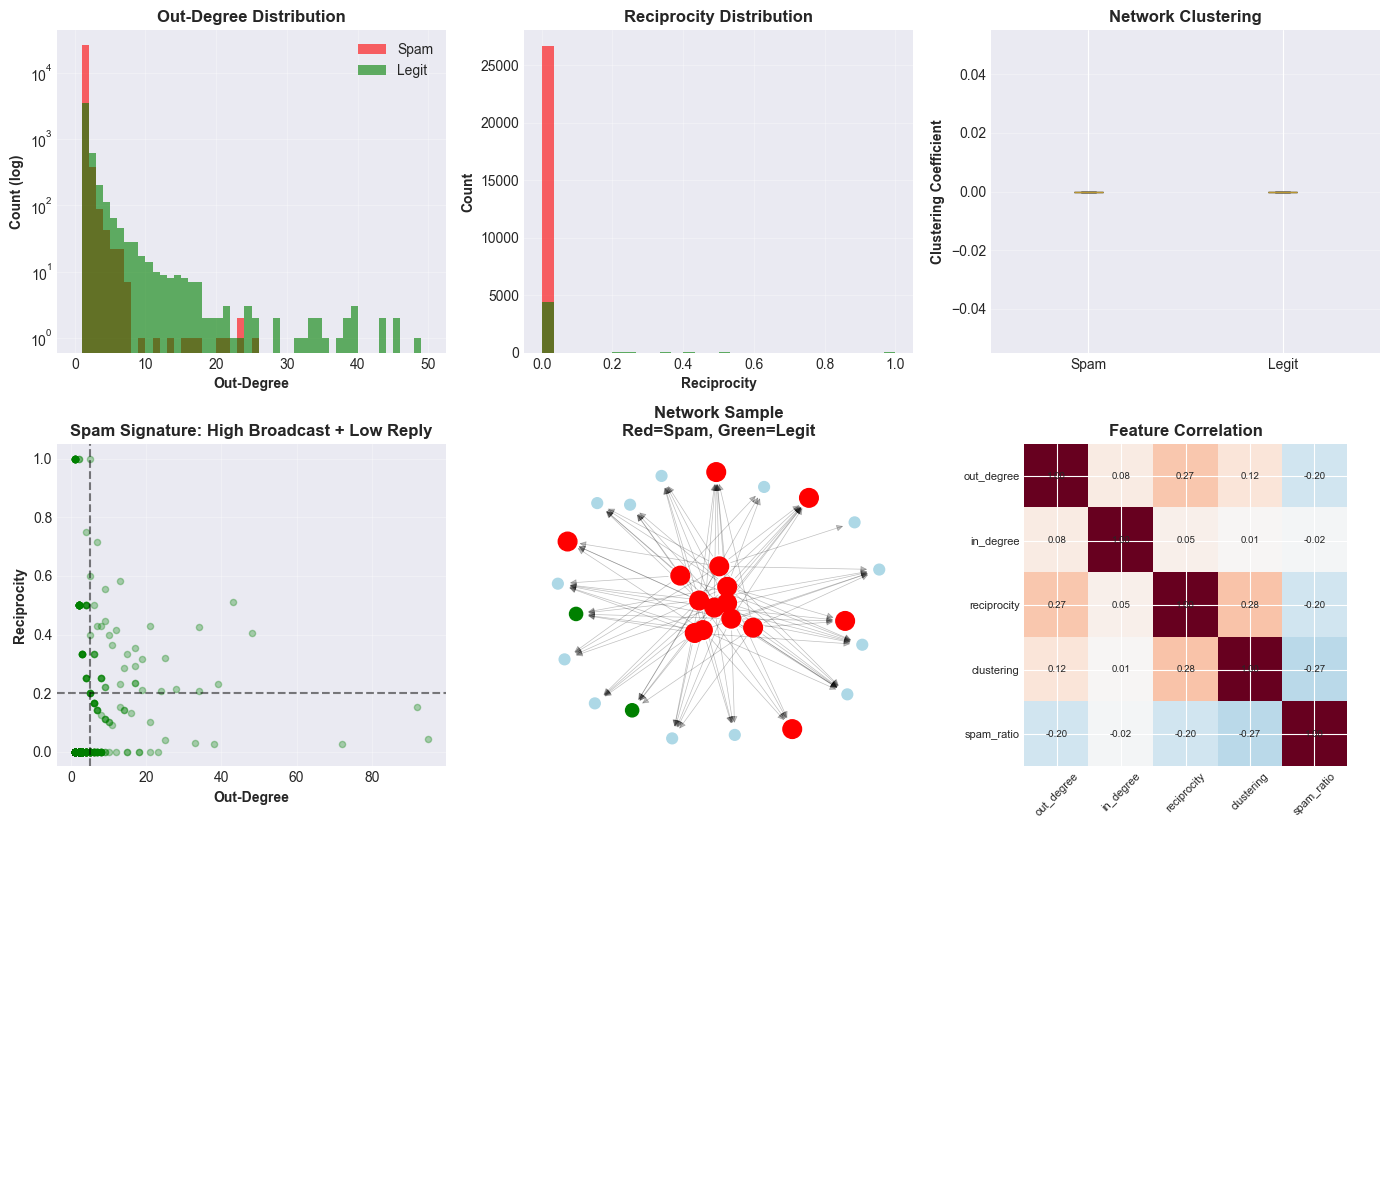

In [73]:
import matplotlib.pyplot as plt
import networkx as nx

# Create 3×3 grid
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
(ax5, ax6, ax7), (ax9, ax10, ax8), (ax_extra1, ax_extra2, ax_extra3) = axes

# ---------------- Panel 1: Out-Degree Histogram ----------------
spam_out = features_df[features_df['is_spammer'] == 1]['out_degree']
legit_out = features_df[features_df['is_spammer'] == 0]['out_degree']

ax5.hist(spam_out, bins=50, alpha=0.6, color='red', label='Spam', range=(0, 50))
ax5.hist(legit_out, bins=50, alpha=0.6, color='green', label='Legit', range=(0, 50))
ax5.set_xlabel('Out-Degree', fontweight='bold')
ax5.set_ylabel('Count (log)', fontweight='bold')
ax5.set_yscale('log')
ax5.set_title('Out-Degree Distribution', fontweight='bold')
ax5.legend(); ax5.grid(alpha=0.3)

# ---------------- Panel 2: Reciprocity Histogram ----------------
spam_recip = features_df[features_df['is_spammer'] == 1]['reciprocity']
legit_recip = features_df[features_df['is_spammer'] == 0]['reciprocity']

ax6.hist(spam_recip, bins=30, alpha=0.6, color='red', range=(0,1))
ax6.hist(legit_recip, bins=30, alpha=0.6, color='green', range=(0,1))
ax6.set_xlabel('Reciprocity', fontweight='bold')
ax6.set_ylabel('Count', fontweight='bold')
ax6.set_title('Reciprocity Distribution', fontweight='bold')
ax6.grid(alpha=0.3)

# ---------------- Panel 3: Clustering ----------------
spam_clust = features_df[features_df['is_spammer'] == 1]['clustering']
legit_clust = features_df[features_df['is_spammer'] == 0]['clustering']

ax7.boxplot([spam_clust, legit_clust], labels=['Spam','Legit'],
            patch_artist=True, showfliers=False)
ax7.set_ylabel('Clustering Coefficient', fontweight='bold')
ax7.set_title('Network Clustering', fontweight='bold')
ax7.grid(axis='y', alpha=0.3)

# ---------------- Panel 4: Scatter Out-degree vs Reciprocity ----------------
spam_sample = features_df[features_df['is_spammer']==1].sample(min(2000, len(spammers)))
legit_sample = features_df[features_df['is_spammer']==0].sample(min(2000, len(legit_users)))

ax9.scatter(spam_sample['out_degree'], spam_sample['reciprocity'], c='red', alpha=0.3, s=20)
ax9.scatter(legit_sample['out_degree'], legit_sample['reciprocity'], c='green', alpha=0.3, s=20)
ax9.axvline(5, ls='--', color='black', alpha=0.5)
ax9.axhline(0.2, ls='--', color='black', alpha=0.5)
ax9.set_title('Spam Signature: High Broadcast + Low Reply', fontweight='bold')
ax9.set_xlabel('Out-Degree', fontweight='bold'); ax9.set_ylabel('Reciprocity', fontweight='bold')
ax9.grid(alpha=0.3)

# ---------------- Panel 5: Network Graph ----------------
top_spammers = features_df[features_df['is_spammer']==1].nlargest(10,'out_degree')['sender']
sample_nodes = set(top_spammers)
for s in top_spammers[:5]:
    sample_nodes.update(list(G.successors(s))[:5])

sample_graph = G.subgraph(sample_nodes)
pos = nx.spring_layout(sample_graph, seed=42)

colors = ['red' if n in spammers else 'green' if n in legit_users else 'lightblue'
          for n in sample_graph.nodes()]
sizes = [180 if n in spammers else 90 if n in legit_users else 60 for n in sample_graph.nodes()]

nx.draw_networkx_edges(sample_graph, pos, ax=ax10, alpha=0.25, arrows=True, width=0.5)
nx.draw_networkx_nodes(sample_graph, pos, ax=ax10, node_color=colors, node_size=sizes)
ax10.set_title('Network Sample\nRed=Spam, Green=Legit', fontweight='bold')
ax10.axis('off')

# ---------------- Panel 6: Correlation Heatmap ----------------
corr_features = ['out_degree','in_degree','reciprocity','clustering','spam_ratio']
corr_matrix = features_df[corr_features].corr()

im = ax8.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax8.set_xticks(range(len(corr_features))); ax8.set_yticks(range(len(corr_features)))
ax8.set_xticklabels(corr_features, rotation=45, fontsize=8)
ax8.set_yticklabels(corr_features, fontsize=8)
ax8.set_title('Feature Correlation', fontweight='bold')
for i in range(len(corr_features)):
    for j in range(len(corr_features)):
        ax8.text(j, i, f'{corr_matrix.iloc[i,j]:.2f}', ha='center', va='center', fontsize=7)

# ---------------- Bottom row: turn off extra panels ----------------
for ax in (ax_extra1, ax_extra2, ax_extra3):
    ax.axis('off')

plt.tight_layout()
plt.show()
